<a href="https://colab.research.google.com/github/sohiniroych/Tensorflow_hub_Webapps/blob/main/Mask_RCNN_Debug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### More models
[This](https://tfhub.dev/tensorflow/collections/object_detection/1) collection contains TF 2 object detection models that have been trained on the COCO 2017 dataset. [Here](https://tfhub.dev/s?module-type=image-object-detection) you can find all object detection models that are currently hosted on [tfhub.dev](https://tfhub.dev/).

## Imports and Setup

Let's start with the base imports.

In [ ]:
# This Colab requires TF 2.5.
!pip install -U tensorflow>=2.5

In [ ]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub
import time

tf.get_logger().setLevel('ERROR')

## Utilities

Run the following cell to create some utils that will be needed later:

- Helper method to load an image
- Map of Model Name to TF Hub handle
- List of tuples with Human Keypoints for the COCO 2017 dataset. This is needed for models with keypoints.

In [ ]:
# @title Run this!!

def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)

COCO17_HUMAN_POSE_KEYPOINTS = [(0, 1),
 (0, 2),
 (1, 3),
 (2, 4),
 (0, 5),
 (0, 6),
 (5, 7),
 (7, 9),
 (6, 8),
 (8, 10),
 (5, 6),
 (5, 11),
 (6, 12),
 (11, 12),
 (11, 13),
 (13, 15),
 (12, 14),
 (14, 16)]


## Visualization tools

To visualize the images with the proper detected boxes, keypoints and segmentation, we will use the TensorFlow Object Detection API. To install it we will clone the repo.

In [ ]:
# Clone the tensorflow models repository
!git clone --depth 1 https://github.com/tensorflow/models/

fatal: destination path 'models' already exists and is not an empty directory.


Intalling the Object Detection API

In [ ]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .


Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1665159 sha256=186d67d4caf5675622dfbe5e11da1ac8b5919f211d37c6dea709e6daec33dfc5
  Stored in directory: /tmp/pip-ephem-wheel-cache-gpa_u6zp/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1




  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


Now we can import the dependencies we will need later

In [ ]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

### Load label map data (for plotting).

Label maps correspond index numbers to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine.

We are going, for simplicity, to load from the repository that we loaded the Object Detection API code

In [ ]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [ ]:
len(category_index)

80

## Build a detection model and load pre-trained model weights

Here we will choose which Object Detection model we will use.
Select the architecture and it will be loaded automatically.
If you want to change the model to try other architectures later, just change the next cell and execute following ones.

## Loading the selected model from TensorFlow Hub

Here we just need the model handle that was selected and use the Tensorflow Hub library to load it to memory.


## Loading an image

Let's try the model on a simple image. To help with this, we provide a list of test images.

Here are some simple things to try out if you are curious:
* Try running inference on your own images, just upload them to colab and load the same way it's done in the cell below.
* Modify some of the input images and see if detection still works.  Some simple things to try out here include flipping the image horizontally, or converting to grayscale (note that we still expect the input image to have 3 channels).

**Be careful:** when using images with an alpha channel, the model expect 3 channels images and the alpha will count as a 4th.



In [ ]:
image_urls = [
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  "https://upload.wikimedia.org/wikipedia/commons/e/e7/ASMjf3188_10.JPG",
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  "https://upload.wikimedia.org/wikipedia/commons/e/e0/Brenner_LKW_Stau.jpg",
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  "https://upload.wikimedia.org/wikipedia/commons/7/71/Tunnel_Pragsattel.jpg",
  ]

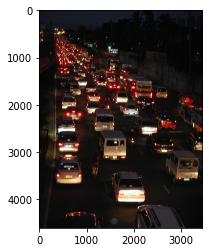

In [ ]:
img_path=image_urls[0]
image_np=load_image_into_numpy_array(img_path)
plt.imshow(image_np[0])

## Doing the inference

To do the inference we just need to call our TF Hub loaded model.

Things you can try:
* Print out `result['detection_boxes']` and try to match the box locations to the boxes in the image.  Notice that coordinates are given in normalized form (i.e., in the interval [0, 1]).
* inspect other output keys present in the result. A full documentation can be seen on the models documentation page (pointing your browser to the model handle printed earlier)

## Generate and Visualize Results

Here is where we will need the TensorFlow Object Detection API to show the squares from the inference step (and the keypoints when available).

Here you can, for example, set `min_score_thresh` to other values (between 0 and 1) to allow more detections in or to filter out more detections.

In [ ]:
model_1="https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1"
print('loading model...')
hub_model_1 = hub.load(model_1)
print('model loaded!')

loading model...
model loaded!


In [ ]:
output_dict=hub_model_1(image_np)

In [ ]:
num_detections = int(output_dict.pop('num_detections'))
#for key,value in output_dict.items():
#      output_dict={key: value[0: num_detections].numpy}

In [ ]:
output_dict = {key:value.numpy() for key,value in output_dict.items()}

In [ ]:
boxes = tf.convert_to_tensor(output_dict['detection_boxes'][0])
detection_masks=tf.convert_to_tensor(output_dict['detection_masks'][0])

In [ ]:
detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, boxes,
              image_np.shape[1], image_np.shape[2])

In [ ]:
detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                      tf.uint8)

In [ ]:
output_dict['detection_masks_reframed']=detection_masks_reframed.numpy()

In [ ]:
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np[0],
      output_dict['detection_boxes'][0],
      (output_dict['detection_classes'][0]).astype(int),
      output_dict['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.10,
      agnostic_mode=False,
      instance_masks=output_dict.get('detection_masks_reframed',None),
      line_thickness=8)



array([[[17, 22, 28],
        [18, 23, 29],
        [18, 23, 29],
        ...,
        [13, 13, 23],
        [13, 13, 23],
        [14, 14, 24]],

       [[18, 23, 29],
        [17, 22, 28],
        [17, 22, 28],
        ...,
        [15, 15, 25],
        [15, 15, 25],
        [14, 14, 24]],

       [[18, 23, 29],
        [17, 22, 28],
        [17, 22, 28],
        ...,
        [16, 16, 26],
        [15, 15, 25],
        [14, 14, 24]],

       ...,

       [[12, 12, 12],
        [12, 12, 12],
        [11, 11, 11],
        ...,
        [ 7,  7,  7],
        [ 7,  7,  7],
        [ 7,  7,  7]],

       [[12, 12, 12],
        [12, 12, 12],
        [11, 11, 11],
        ...,
        [ 8,  8,  8],
        [ 8,  8,  8],
        [ 8,  8,  8]],

       [[13, 13, 13],
        [13, 13, 13],
        [12, 12, 12],
        ...,
        [ 8,  8,  8],
        [ 9,  9,  9],
        [ 9,  9,  9]]], dtype=uint8)

In [ ]:
plt.figure(figsize=(24,32))
plt.imshow(image_np[0])
plt.show()

In [ ]:
import base64
def encode_image(img):
  image_buffer = io.BytesIO()
  img.save(image_buffer, format='PNG')
  imgstr = 'data:image/png;base64,{:s}'.format(
      base64.b64encode(image_buffer.getvalue()).decode().replace("'", ""))
  return imgstr

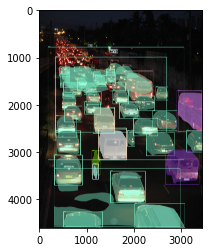

In [ ]:
plt.imshow(image_np[0])